In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
import seaborn as sns

import pickle

from glob import glob
import numpy as np
import struct

#import setup
from astropy.table import Table
#Coordinate
from astropy.coordinates import SkyCoord
from astropy import units as u
#from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.io import fits

from scipy.stats import chi2
from scipy.special import gamma

import pandas as pd
from tqdm import tqdm
import math

import pickle
#from matched_clusters import matched_clusters
#from matched_clusters_plot import *

from astropy.table import Table
import emcee
import pygtc

In [40]:
# the following commands make plots look better
def plot_prettier(dpi=200, fontsize=10): 
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    
plot_prettier()

In [63]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, c='blue', label='label'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=2, c=c, label=label)

    # now determine nice limits by hand:
    #binwidth = 100
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #xymax = 10000
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins='auto', histtype='step', color=c, density=True)
    ax_histy.hist(y, bins='auto', histtype='step', color=c, orientation='horizontal', density=True)

In [64]:

cols = ['mem_match_id','ra','dec','z','refmag'
        ,'refmag_err','lambda','lambda_e','z_lambda'
        ,'z_lambda_e','cg_spec_z','z_spec_init'
        ,'z_init','r_lambda','r_mask','scaleval'
        ,'maskfrac','zred','zred_e','zred_chisq'
        ,'chisq','z_lambda_niter','ebv_mean'
        ,'lnlamlike','lncglike','lnlike'
        ,'ra_orig','dec_orig','w','dlambda_dz'
        ,'dlambda_dz2','dlambdavar_dz'
        ,'dlambdavar_dz2','z_lambda_raw'
        ,'z_lambda_e_raw','bkg_local','lim_exptime'
        ,'lim_limmag','lim_limmag_hard','lambda_c'
        ,'lambda_ce','ncent_good','maskgal_index'
        ,'comvd','matched','centered','halo_ID'
        ,'halo_RA','halo_Dec','halo_z','halo_M'
        ,'halo_comv','propD_sep','z_sep']

## Read the saved matched clusters. 
matched_pkl = 'cosmodc2_matched_cloonan.pkl'
    
with open(matched_pkl, 'rb') as inp:
    matched_cl = pickle.load(inp)
    
cent_cl = matched_cl[cols][matched_cl['centered'] == True].to_pandas()
misc_cl = matched_cl[cols][matched_cl['centered'] == False].to_pandas()
    
matched_cl.columns

<TableColumns names=('mem_match_id','ra','dec','z','refmag','refmag_err','lambda','lambda_e','z_lambda','z_lambda_e','cg_spec_z','z_spec_init','z_init','r_lambda','r_mask','scaleval','maskfrac','zred','zred_e','zred_chisq','chisq','z_lambda_niter','ebv_mean','lnlamlike','lncglike','lnlike','ra_orig','dec_orig','w','dlambda_dz','dlambda_dz2','dlambdavar_dz','dlambdavar_dz2','z_lambda_raw','z_lambda_e_raw','bkg_local','lim_exptime','lim_limmag','lim_limmag_hard','lambda_c','lambda_ce','ncent_good','maskgal_index','mag','mag_err','pzbins','pz','ra_cent','dec_cent','id_cent','lambda_cent','zlambda_cent','p_cen','q_cen','p_fg','q_miss','p_sat','p_c','comvd','matched','centered','halo_ID','halo_RA','halo_Dec','halo_z','halo_M','halo_comv','propD_sep','z_sep')>

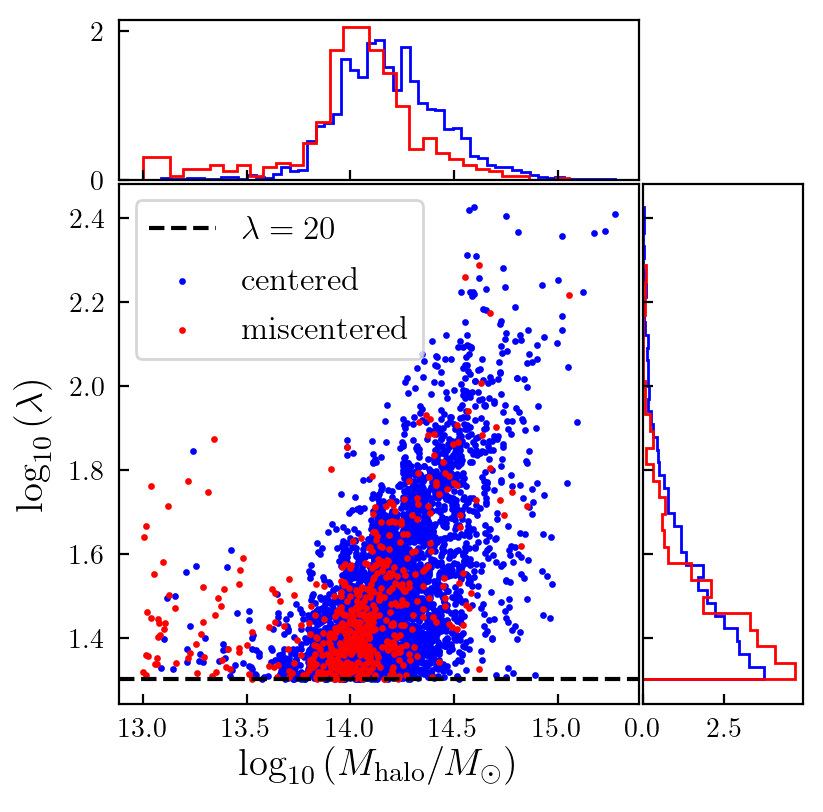

In [122]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(4,4))

ax = fig.add_axes(rect_scatter)

ax.set_xlabel(r'$\log_{10}{(M_{\rm halo} / M_\odot)}$', fontsize=14)
ax.set_ylabel(r'$\log_{10}{(\lambda)}$', fontsize=14)
ax.axhline(np.log10(20), linestyle='--', c='black', label=r'$\lambda = 20$')

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(np.log10(cent_cl['halo_M']), np.log10(cent_cl['lambda'])
             , ax, ax_histx, ax_histy
             , 'blue', 'centered')
scatter_hist(np.log10(misc_cl['halo_M']), np.log10(misc_cl['lambda'])
             , ax, ax_histx, ax_histy
             , 'red', 'miscentered')

ax.legend(loc='upper left', fontsize=12)

#plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig('figures/richness_mass.jpg', bbox_inches="tight",format='jpeg')
plt.show()

# label with ylabel and legend

In [131]:
nbins = 10
lambda_range = (1.3, 2.5)
#error for mass
mass_range = (13.5,15.)

nm, _ = np.histogram(np.log10(cent_cl['halo_M']), bins=nbins, range=mass_range)
sym, _ = np.histogram(np.log10(cent_cl['halo_M']), bins=nbins, weights=np.log10(cent_cl['lambda']), range=mass_range)
sy2m, m_bins = np.histogram(np.log10(cent_cl['halo_M']), bins=nbins, weights=np.log10(cent_cl['lambda'])**2., range=mass_range)
lambda_mean_cent = sym / nm
lambda_std_cent = np.sqrt(sy2m/nm - lambda_mean_cent**2.)

nm, _ = np.histogram(np.log10(misc_cl['halo_M']), bins=nbins, range=mass_range)
sym, _ = np.histogram(np.log10(misc_cl['halo_M']), bins=nbins, weights=np.log10(misc_cl['lambda']), range=mass_range)
sy2m, m_bins = np.histogram(np.log10(misc_cl['halo_M']), bins=nbins, weights=np.log10(misc_cl['lambda'])**2., range=mass_range)
lambda_mean_misc = sym / nm
lambda_std_misc = np.sqrt(sy2m/nm - lambda_mean_misc**2.)


(13.5, 15)

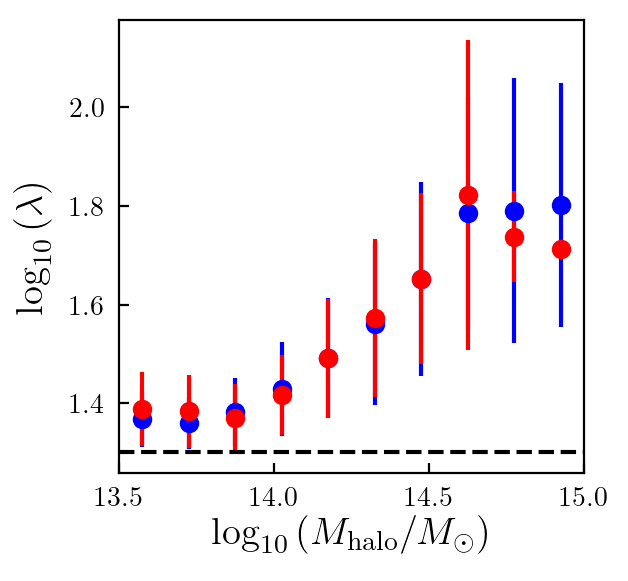

In [136]:

fig, ax = plt.subplots(1,1, figsize=(3,3))
plt.errorbar((m_bins[1:] + m_bins[:-1])/2, lambda_mean_cent, yerr=lambda_std_cent, c='blue', fmt='o')
plt.errorbar((m_bins[1:] + m_bins[:-1])/2, lambda_mean_misc, yerr=lambda_std_misc, c='red', fmt='o')

ax.set_xlabel(r'$\log_{10}{(M_{\rm halo} / M_\odot)}$', fontsize=14)
ax.set_ylabel(r'$\log_{10}{(\lambda)}$', fontsize=14)
ax.axhline(np.log10(20), linestyle='--', c='black', label=r'$\lambda = 20$')

ax.set_xlim(13.5, 15)

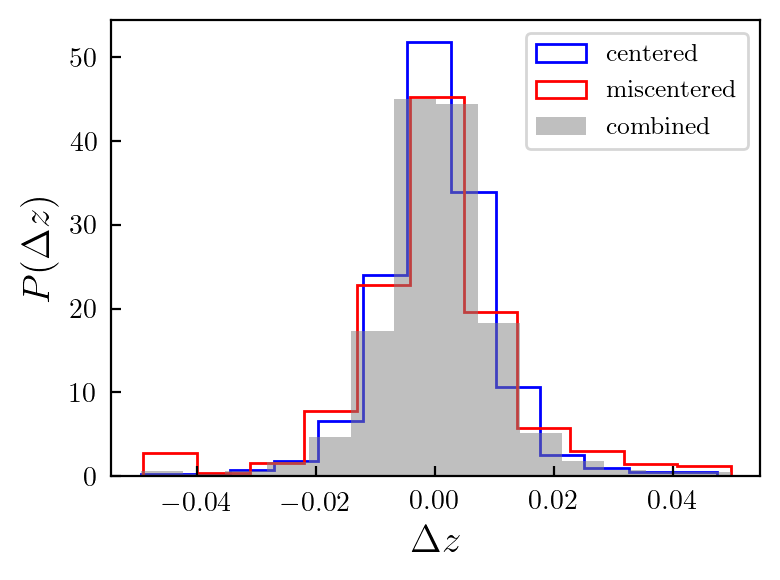

In [124]:
###This is how I would plot it
plt.figure(figsize=(4,3), tight_layout=True)
plt.hist(cent_cl['z_sep'], bins='sturges', density=True, histtype='step', fill=False, color='blue', label='centered')
plt.hist(misc_cl['z_sep'], bins='sturges', density=True, histtype='step', fill=False, color='red', label='miscentered')
plt.hist(matched_cl['z_sep'], bins='sturges', density=True, alpha=0.5, color='grey', label='combined')
plt.xlabel(r'$\Delta z$', fontsize=14)
plt.ylabel(r'$P(\Delta z)$', fontsize=14)
plt.legend(fontsize=9, loc='best')
plt.savefig('figures/zsep_hist.jpg', bbox_inches="tight", format='jpg')
plt.show()

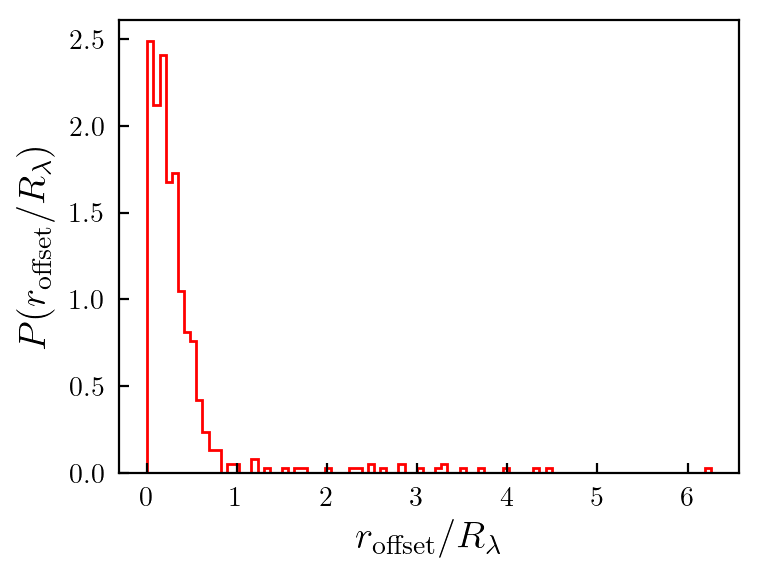

In [125]:
misc_cl['offset_Rlambda'] = misc_cl.apply(lambda row: (row['propD_sep']/1000)/(row['r_lambda']), axis = 1)
offset = misc_cl['offset_Rlambda']

plt.figure(figsize=(4,3))
plt.hist(offset, bins='auto', density=True, histtype='step', fill=False, color='red')
#plt.plot(x, px, 'r')
plt.xlabel(r'$r_{\rm offset}/R_\lambda$', fontsize=14)
plt.ylabel(r'$P(r_{\rm offset}/R_\lambda)$', fontsize=14)
#plt.xlim(0, 1)
plt.savefig('figures/misc_hist.jpg', bbox_inches='tight', format='jpeg')